#  LSTM+ CRF 实体命名识别（二）
 参见blog： https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/

In [4]:
import pandas as pd
import numpy as np
data =pd.read_csv("ner_dataset.csv",encoding="latin1")

#训练数据的格式为
![数据格式](data.PNG)

In [5]:
data=data.fillna(method="ffill")

In [6]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [24]:
words=list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words


35179

In [8]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [9]:
#创建一个类来获取句子，pos，tag
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [10]:
getter = SentenceGetter(data)

In [11]:
sent=getter.get_next() #获取一个sentence


In [12]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [13]:
#获取全部句子sentence
sentences=getter.sentences


## 准备数据
我们准备了文字和标签的字典

In [14]:
max_len=75
word2idx={w:i+1 for  i ,w in enumerate(words)}
tag2idx={t:i for i,t in enumerate(tags)}

In [15]:
word2idx["Obama"]

32519

In [16]:
tag2idx["B-geo"]

16

In [17]:
#将句子转换为序列，并用0 填充
from keras.preprocessing.sequence import pad_sequences
X=[[word2idx[w[0]] for w in s] for s in sentences]

In [18]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [19]:
#同样的方式处理tags
y=[[tag2idx[w[2]] for w in s] for  s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [20]:
#为了训练网络，我们还需要将标签y改为categories。
from keras.utils import to_categorical
y=[to_categorical(i,num_classes=n_tags) for i in y]

In [21]:
# 将数据集分为训练数据和测试数据
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [22]:
print(len(X_tr))

43163


In [23]:
#建立CRF_LSTM
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF


In [25]:
max_len=75

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [26]:
model = Model(input, out)

In [27]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [28]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 130s 3ms/step - loss: 0.1092 - acc: 0.9699 - val_loss: 0.0464 - val_acc: 0.9845
Epoch 2/5
38846/38846 [==============================] - 124s 3ms/step - loss: 0.0348 - acc: 0.9874 - val_loss: 0.0305 - val_acc: 0.9886
Epoch 3/5
38846/38846 [==============================] - 124s 3ms/step - loss: 0.0246 - acc: 0.9901 - val_loss: 0.0260 - val_acc: 0.9893
Epoch 4/5
38846/38846 [==============================] - 122s 3ms/step - loss: 0.0210 - acc: 0.9912 - val_loss: 0.0241 - val_acc: 0.9900
Epoch 5/5
38846/38846 [==============================] - 123s 3ms/step - loss: 0.0191 - acc: 0.9918 - val_loss: 0.0230 - val_acc: 0.9902


In [30]:
hist = pd.DataFrame(history.history)

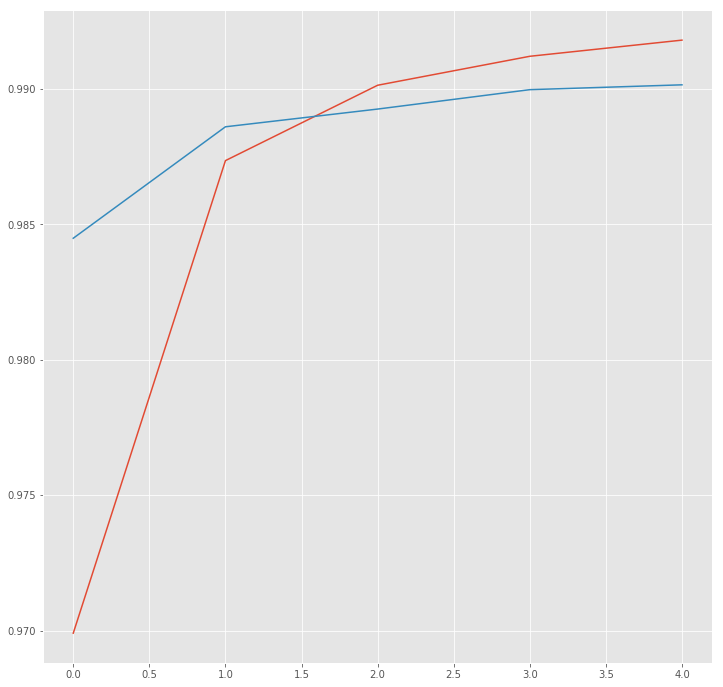

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [38]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [39]:
test_pred = model.predict(X_te, verbose=1)

4796/4796 [==============================] - 4s 831us/step


In [36]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [41]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 83.1%


In [42]:
print(classification_report(test_labels, pred_labels))

             precision    recall  f1-score   support

        geo       0.85      0.88      0.87      3733
        gpe       0.97      0.92      0.94      1604
        tim       0.89      0.87      0.88      2027
        org       0.72      0.67      0.70      2031
        per       0.77      0.76      0.77      1641
        eve       0.80      0.17      0.29        23
        art       0.00      0.00      0.00        46
        nat       0.00      0.00      0.00        19

avg / total       0.83      0.82      0.83     11124



In [45]:
# 预测
i = 1050
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
Spider-Man     : O     O
3              : O     O
smashed        : O     O
U.S.           : B-geo B-geo
box            : O     O
office         : O     O
records        : O     O
last           : O     O
weekend        : B-tim B-tim
,              : O     O
netting        : O     O
$              : O     O
148            : O     O
million        : O     O
in             : O     O
its            : O     O
first          : B-tim B-tim
three          : I-tim I-tim
days           : O     O
of             : B-tim O
release        : I-tim O
.              : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong           : O     O
Dong 

In [46]:
# LSTM - CRF 的推理
test_sentence = ["Hawking", "was", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]


## 现在我们把每个单词都转换成整数索引。注意，我们将未知单词映射为0。通常情况下，您需要向您的词汇表中添加一个未知的令牌。然后，减少训练模型的词汇量，用未知的标记替换所有不常见的单词

In [47]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)

In [48]:
#预测模型
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction
Hawking        : O    
was            : O    
a              : O    
Fellow         : O    
of             : O    
the            : O    
Royal          : B-org
Society        : I-org
,              : O    
a              : O    
lifetime       : O    
member         : O    
of             : O    
the            : O    
Pontifical     : B-org
Academy        : I-org
of             : I-org
Sciences       : I-org
,              : O    
and            : O    
a              : O    
recipient      : O    
of             : O    
the            : O    
Presidential   : O    
Medal          : O    
of             : O    
Freedom        : B-geo
,              : O    
the            : O    
highest        : O    
civilian       : O    
award          : O    
in             : O    
the            : O    
United         : B-geo
States         : I-geo
.              : O    
